In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''


## Gaussian Processes

In Section 6.1, we introduced kernels by applying the concept of duality to a non-probabilistic model for regression. Here we extend the role of kernels to probabilistic discriminative models, leading to the framework of **Gaussian processes**. We shall thereby see how kernels arise naturally in a Bayesian setting.

## Linear Regression Revisited

In order to motivate the **Gaussian process** viewpoint, let us return to the linear regression example and re-derive the predictive distribution by working in terms of distributions over functions $ y(x, w) $. This will provide a specific example of a Gaussian process.

Consider a model defined in terms of a linear combination of $ M $ fixed basis functions given by the elements of the vector $ \phi(x) $ so that

$$
y(x) = w^T \phi(x)
$$

where $ x $ is the input vector and $ w $ is the $ M $-dimensional weight vector. Now consider a prior distribution over $ w $ given by an isotropic Gaussian of the form

$$
p(w) = \mathcal{N}(w|0, \alpha^{-1} I)
$$

governed by the hyperparameter $ \alpha $, which represents the precision (inverse variance) of the distribution. For any given value of $ w $, the definition $ y(x) = w^T \phi(x) $ defines a particular function of $ x $. The probability distribution over $ w $ therefore induces a probability distribution over functions $ y(x) $.

### Joint Distribution of Function Values

In practice, we wish to evaluate this function at specific values of $ x $, for example, at the training data points $ x_1, \dots, x_N $. We are therefore interested in the joint distribution of the function values $ y(x_1), \dots, y(x_N) $, which we denote by the vector $ y $ with elements

$$
y_n = y(x_n), \quad n = 1, \dots, N.
$$

From $ y(x) = w^T \phi(x) $, this vector is given by

$$
y = \Phi w
$$

where $ \Phi $ is the design matrix with elements $ \Phi_{nk} = \phi_k(x_n) $.

We can find the probability distribution of $ y $ as follows. Since $ y $ is a linear combination of Gaussian distributed variables (given by the elements of $ w $), it is itself Gaussian. Therefore, we need to find its mean and covariance, which are given by

$$
E[y] = \Phi E[w] = 0
$$

and

$$
\text{cov}[y] = E[yy^T] = \Phi E[ww^T] \Phi^T = \Phi \Phi^T = K
$$

where $ K $ is the Gram matrix with elements

$$
K_{nm} = k(x_n, x_m) = \phi(x_n)^T \phi(x_m)
$$

and $ k(x, x') $ is the kernel function. This model provides us with a particular example of a **Gaussian process**.

In general, a **Gaussian process** is defined as a probability distribution over functions $ y(x) $ such that the set of values $ y(x_1), \dots, y(x_N) $ evaluated at an arbitrary set of points $ x_1, \dots, x_N $ jointly have a Gaussian distribution. In cases where the input vector $ x $ is two-dimensional, this may also be known as a **Gaussian random field**.

### Gaussian Process Definition

A key point about Gaussian stochastic processes is that the joint distribution over $ N $ variables $ y_1, \dots, y_N $ is specified completely by the second-order statistics, namely the mean and the covariance. In most applications, we will not have any prior knowledge about the mean of $ y(x) $, so by symmetry, we take it to be zero. This is equivalent to choosing the mean of the prior over weight values $ p(w | \alpha) $ to be zero in the basis function viewpoint.

The specification of the Gaussian process is then completed by giving the covariance of $ y(x) $ evaluated at any two values of $ x $, which is given by the kernel function

$$
E[y(x_n) y(x_m)] = k(x_n, x_m)
$$

For the specific case of a Gaussian process defined by the linear regression model with a weight prior, the kernel function is given by

$$
k(x_n, x_m) = \phi(x_n)^T \phi(x_m)
$$

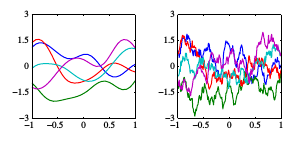

Fig.4 Samples from Gaussian processes for a ‘Gaussian’ kernel (left) and an exponential kernel (right).



We can also define the kernel function directly, rather than indirectly through a choice of basis function. Fig.4 shows samples of functions drawn from Gaussian processes for two different choices of kernel function. The first of these is a **Gaussian kernel** of the form

$$
k(x, x') = \exp \left( - \frac{|x - x'|^2}{2\sigma^2} \right)
$$

and the second is the **exponential kernel** given by

$$
k(x, x') = \exp \left( - \theta |x - x'| \right)
$$

which corresponds to the **Ornstein-Uhlenbeck process**, originally introduced by Uhlenbeck and Ornstein (1930) to describe Brownian motion.



/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


ValueError: operands could not be broadcast together with shapes (100,) (10000,) 

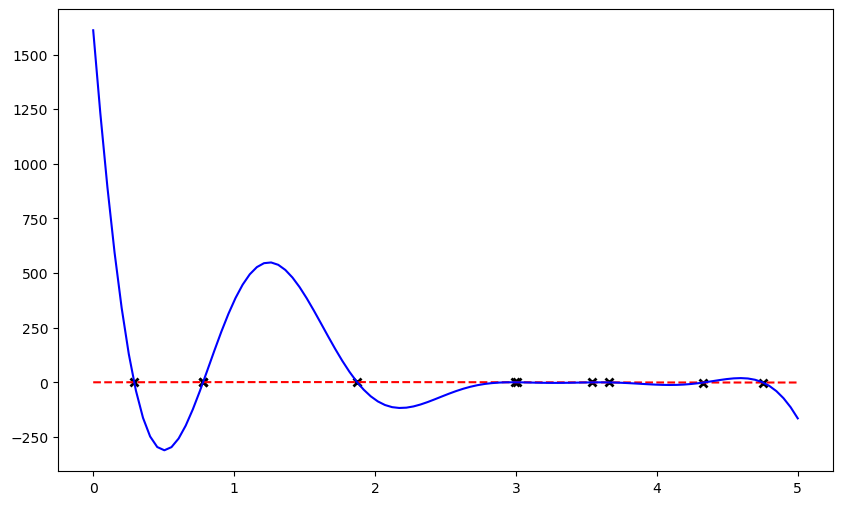

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the kernel function
def rbf_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """
    Radial Basis Function (RBF) kernel, also known as Gaussian kernel.
    k(x1, x2) = sigma_f^2 * exp(-||x1 - x2||^2 / (2 * length_scale^2))
    """
    sqdist = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# Gaussian Process Regression
def gaussian_process(X_train, y_train, X_test, kernel, sigma_y=1e-8):
    """
    Gaussian Process Regression implementation.
    
    Parameters:
    - X_train: Training inputs (N x D).
    - y_train: Training outputs (N x 1).
    - X_test: Test inputs (M x D).
    - kernel: Kernel function.
    - sigma_y: Noise variance.
    
    Returns:
    - mu_s: Predictive mean (M x 1).
    - cov_s: Predictive covariance (M x M).
    """
    # Compute the covariance matrices
    K = kernel(X_train, X_train) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_test)
    K_ss = kernel(X_test, X_test) + sigma_y**2 * np.eye(len(X_test))
    
    # Compute the mean and covariance of the posterior
    K_inv = np.linalg.inv(K)
    mu_s = K_s.T @ K_inv @ y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

# Generate sample data
np.random.seed(42)
X_train = np.random.uniform(0, 5, (10, 1))  # 10 training points in [0, 5]
y_train = np.sin(X_train) + 0.1 * np.random.randn(*X_train.shape)  # Noisy sine function

X_test = np.linspace(0, 5, 100).reshape(-1, 1)  # 100 test points in [0, 5]

# Perform Gaussian Process Regression
length_scale = 1.0
sigma_f = 1.0
mu_s, cov_s = gaussian_process(X_train, y_train, X_test, 
                               lambda x1, x2: rbf_kernel(x1, x2, length_scale, sigma_f))

# Extract the standard deviation from the covariance
std_s = np.sqrt(np.diag(cov_s))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'kx', mew=2, label="Training Points")
plt.plot(X_test, np.sin(X_test), 'r--', label="True Function")
plt.plot(X_test, mu_s, 'b', label="Mean Prediction")
plt.fill_between(X_test.flatten(), 
                 (mu_s - 2 * std_s).flatten(), 
                 (mu_s + 2 * std_s).flatten(), 
                 color='blue', alpha=0.2, label="Confidence Interval (2 std)")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian Process Regression")
plt.show()


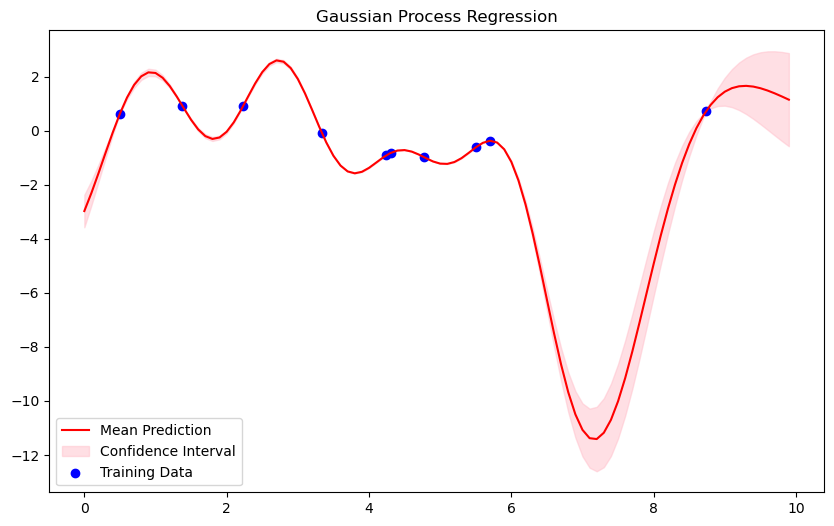

In [3]:
import math
import random
import matplotlib.pyplot as plt

# Helper function to compute the squared exponential kernel
def squared_exponential_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """
    Computes the squared exponential (Gaussian) kernel between two points.
    """
    diff = x1 - x2
    return sigma_f ** 2 * math.exp(-0.5 * (diff ** 2) / (length_scale ** 2))

# Matrix inversion using Gaussian elimination with partial pivoting
def invert_matrix(matrix):
    """
    Compute the inverse of a square matrix using Gaussian elimination with partial pivoting.
    """
    n = len(matrix)
    identity = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
    augmented = [matrix[i] + identity[i] for i in range(n)]
    
    # Gaussian elimination with pivoting
    for i in range(n):
        # Pivot selection
        max_row = max(range(i, n), key=lambda k: abs(augmented[k][i]))
        augmented[i], augmented[max_row] = augmented[max_row], augmented[i]
        
        # Make the diagonal element 1
        diag_element = augmented[i][i]
        for j in range(2 * n):
            augmented[i][j] /= diag_element
        
        # Make other elements in the column 0
        for k in range(n):
            if k != i:
                factor = augmented[k][i]
                for j in range(2 * n):
                    augmented[k][j] -= factor * augmented[i][j]
    
    # Extract the inverse matrix
    return [row[n:] for row in augmented]

# Helper function to multiply two matrices
def multiply_matrices(A, B):
    """
    Multiplies two matrices A and B.
    """
    rows_A, cols_A = len(A), len(A[0])
    rows_B, cols_B = len(B), len(B[0])
    
    if cols_A != rows_B:
        raise ValueError("Number of columns in A must equal number of rows in B")
    
    result = [[0 for _ in range(cols_B)] for _ in range(rows_A)]
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                result[i][j] += A[i][k] * B[k][j]
    return result

# Gaussian Process Regression
def gaussian_process(x_train, y_train, x_test, length_scale=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Performs Gaussian Process Regression.
    """
    n_train = len(x_train)
    n_test = len(x_test)
    
    # Compute the kernel matrix for training data
    K = [[squared_exponential_kernel(x_train[i], x_train[j], length_scale, sigma_f) for j in range(n_train)] for i in range(n_train)]
    
    # Add noise variance to the diagonal
    for i in range(n_train):
        K[i][i] += sigma_y
    
    # Compute the kernel between training and test data
    K_s = [[squared_exponential_kernel(x_train[i], x_test[j], length_scale, sigma_f) for j in range(n_test)] for i in range(n_train)]
    
    # Compute the kernel for the test data
    K_ss = [[squared_exponential_kernel(x_test[i], x_test[j], length_scale, sigma_f) for j in range(n_test)] for i in range(n_test)]
    
    # Invert the training kernel matrix
    K_inv = invert_matrix(K)
    
    # Compute the mean of the posterior
    K_s_T = [[K_s[j][i] for j in range(n_train)] for i in range(n_test)]  # Transpose of K_s
    mu_s = multiply_matrices(K_s_T, multiply_matrices(K_inv, [[y] for y in y_train]))
    mu_s = [row[0] for row in mu_s]  # Flatten to a list
    
    # Compute the covariance of the posterior
    temp = multiply_matrices(K_s_T, K_inv)
    cov_s = [[K_ss[i][j] - sum(temp[i][k] * K_s[k][j] for k in range(n_train)) for j in range(n_test)] for i in range(n_test)]
    
    return mu_s, cov_s

# Generate synthetic data
def generate_data():
    """
    Generates synthetic data for regression.
    """
    x_train = [random.uniform(0, 10) for _ in range(10)]
    y_train = [math.sin(x) + random.gauss(0, 0.1) for x in x_train]
    x_test = [i / 100.0 * 10 for i in range(100)]
    return x_train, y_train, x_test

# Plot the results
def plot_gp(x_train, y_train, x_test, mu_s, cov_s):
    """
    Plots the results of Gaussian Process Regression.
    """
    std_s = [math.sqrt(max(cov_s[i][i], 0)) for i in range(len(cov_s))]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_test, mu_s, 'r-', label='Mean Prediction')
    plt.fill_between(x_test, [mu_s[i] - 2 * std_s[i] for i in range(len(mu_s))], 
                     [mu_s[i] + 2 * std_s[i] for i in range(len(mu_s))], color='pink', alpha=0.5, label='Confidence Interval')
    plt.scatter(x_train, y_train, c='blue', label='Training Data')
    plt.legend()
    plt.title('Gaussian Process Regression')
    plt.show()

# Main execution
x_train, y_train, x_test = generate_data()
mu_s, cov_s = gaussian_process(x_train, y_train, x_test)
plot_gp(x_train, y_train, x_test, mu_s, cov_s)


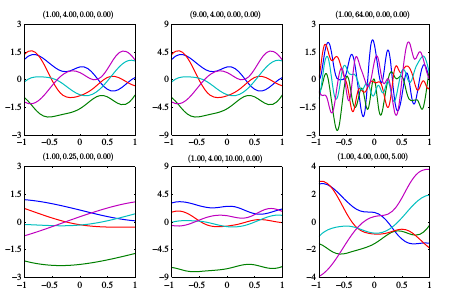
## Gaussian Processes for Regression

To model regression problems using Gaussian Processes (GPs), we consider observations $ t_n $ that are related to the underlying function values $ y_n = y(x_n) $ through additive Gaussian noise:

$$
t_n = y_n + \epsilon_n,
$$

where $ \epsilon_n \sim \mathcal{N}(0, \beta^{-1}) $ is an independent noise term with precision $ \beta $.

### Likelihood of Observed Data

Given the Gaussian noise model, the conditional likelihood of the observed target values $ t = (t_1, \dots, t_N)^\top $ given $ y = (y_1, \dots, y_N)^\top $ is:

$$
p(t|y) = \mathcal{N}(t|y, \beta^{-1}I_N),
$$

where \( I_N \) is the $ N \times N $ identity matrix.

### Marginal Prior over \( y \)

The GP defines a prior over functions \( y(x) \), which induces a joint Gaussian prior over the values of \( y \) at the observed input points:

$$
p(y) = \mathcal{N}(y|0, K),
$$

where $ K $ is the covariance matrix with elements $ K_{nm} = k(x_n, x_m) $ determined by the kernel function $ k(x_n, x_m) $.

### Marginalizing \( y \)

To find the marginal distribution of \( t \), we integrate out \( y \):

$$
p(t) = \int p(t|y)p(y) \, dy = \mathcal{N}(t|0, C),
$$

where the covariance matrix \( C \) is given by:

$$
C(x_n, x_m) = k(x_n, x_m) + \beta^{-1} \delta_{nm}.
$$

Here, \( \delta_{nm} \) is the Kronecker delta.

### Kernel Function

A commonly used kernel function combines an exponential quadratic term with linear and constant components:

$$
k(x_n, x_m) = \theta_0 \exp \left( -\frac{\|x_n - x_m\|^2}{2\theta_1^2} \right) + \theta_2 + \theta_3 x_n^\top x_m.
$$

- The term involving $ \theta_3 $ corresponds to a linear parametric model.

### Predictive Distribution

To predict the target $ t_{N+1} $ for a new input $ x_{N+1} $, we compute the conditional distribution:

$$
p(t_{N+1}|t) = \mathcal{N}(t_{N+1}|\mu_{N+1}, \sigma_{N+1}^2).
$$

#### Partitioning the Covariance Matrix

The joint distribution over $ t_1, \dots, t_N, t_{N+1} $ is:

$$
p(t_{N+1}) = \mathcal{N}(t_{N+1}|0, C_{N+1}),
$$

where the covariance matrix $ C_{N+1} $ is partitioned as:

$$
C_{N+1} =
\begin{bmatrix}
C_N & k \\
k^\top & c
\end{bmatrix}.
$$

- $ C_N $: Covariance matrix of training data.  
- $ k $: Covariance vector between training points and $ x_{N+1} $.  
- $ c $: Covariance at $ x_{N+1} $, i.e., $ k(x_{N+1}, x_{N+1}) $.

#### Predictive Mean and Variance

Using properties of Gaussian distributions, the predictive mean and variance are:

$$
\mu_{N+1} = k^\top C_N^{-1} t,
$$

$$
\sigma_{N+1}^2 = c - k^\top C_N^{-1} k.
$$


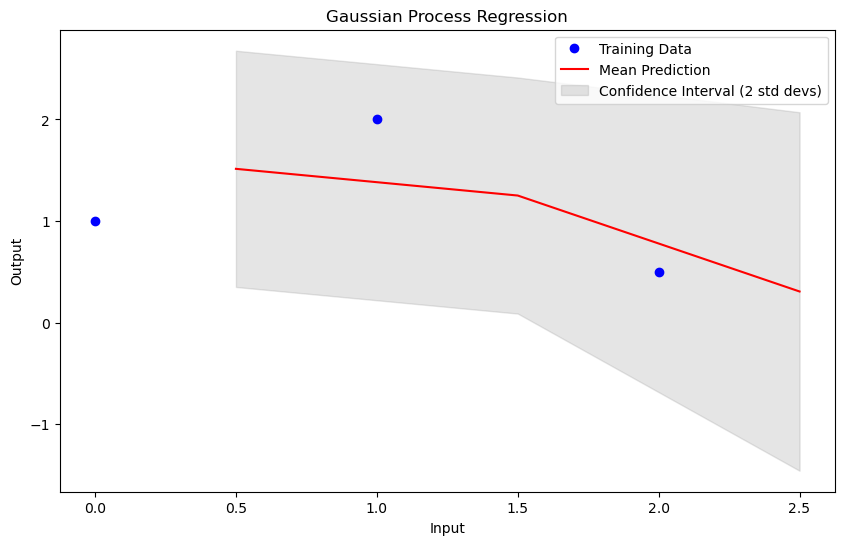

In [4]:
import math
import matplotlib.pyplot as plt

# Define the kernel function
def kernel(x1, x2, theta):
    # Squared Exponential Kernel + Linear Term + Constant
    sq_dist = sum((x1[i] - x2[i]) ** 2 for i in range(len(x1)))
    return (
        theta[0] * math.exp(-0.5 * sq_dist / theta[1])
        + theta[2]
        + theta[3] * sum(x1[i] * x2[i] for i in range(len(x1)))
    )

# Matrix inversion using Gaussian elimination (for simplicity)
def matrix_inverse(mat):
    n = len(mat)
    identity = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
    for i in range(n):
        diag_elem = mat[i][i]
        for j in range(n):
            mat[i][j] /= diag_elem
            identity[i][j] /= diag_elem
        for k in range(n):
            if k != i:
                factor = mat[k][i]
                for j in range(n):
                    mat[k][j] -= factor * mat[i][j]
                    identity[k][j] -= factor * identity[i][j]
    return identity

# Matrix multiplication
def matrix_multiply(A, B):
    rows_A, cols_A = len(A), len(A[0])
    rows_B, cols_B = len(B), len(B[0])
    if cols_A != rows_B:
        raise ValueError("Matrix dimensions do not match for multiplication")
    return [
        [sum(A[i][k] * B[k][j] for k in range(cols_A)) for j in range(cols_B)]
        for i in range(rows_A)
    ]

# Main Gaussian Process Regression function
def gaussian_process_regression(X_train, y_train, X_test, theta, beta):
    # Construct the covariance matrix for training data
    K = [
        [kernel(X_train[i], X_train[j], theta) for j in range(len(X_train))]
        for i in range(len(X_train))
    ]

    # Add noise term to covariance matrix
    for i in range(len(K)):
        K[i][i] += 1 / beta

    # Invert the covariance matrix
    K_inv = matrix_inverse([row[:] for row in K])  # Copy to avoid modifying K

    # Compute the mean and variance for test data
    predictions = []
    for x_star in X_test:
        # Compute k (covariance vector between training and test point)
        k = [kernel(X_train[i], x_star, theta) for i in range(len(X_train))]

        # Predictive mean
        k_T = [[k[i]] for i in range(len(k))]
        mean = sum(k[i] * sum(K_inv[i][j] * y_train[j] for j in range(len(y_train))) for i in range(len(k)))

        # Predictive variance
        c = kernel(x_star, x_star, theta) + 1 / beta
        variance = c - sum(k[i] * sum(K_inv[i][j] * k[j] for j in range(len(k))) for i in range(len(k)))

        predictions.append((mean, variance))

    return predictions

# Example data and parameters
X_train = [[0.0], [1.0], [2.0]]
y_train = [1.0, 2.0, 0.5]
X_test = [[0.5], [1.5], [2.5]]
theta = [1.0, 1.0, 1.0, 1.0]  # Hyperparameters for the kernel
beta = 5.0  # Noise precision

# Perform Gaussian Process Regression
predictions = gaussian_process_regression(X_train, y_train, X_test, theta, beta)

# Plot the results
means = [p[0] for p in predictions]
std_devs = [math.sqrt(p[1]) for p in predictions]
X_test_flat = [x[0] for x in X_test]

plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in X_train], y_train, "bo", label="Training Data")
plt.plot(X_test_flat, means, "r-", label="Mean Prediction")
plt.fill_between(
    X_test_flat,
    [m - 2 * s for m, s in zip(means, std_devs)],
    [m + 2 * s for m, s in zip(means, std_devs)],
    color="gray",
    alpha=0.2,
    label="Confidence Interval (2 std devs)",
)
plt.legend()
plt.title("Gaussian Process Regression")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()


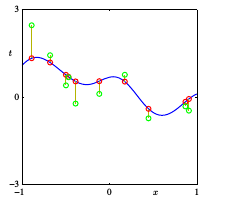

Fig.6 Illustration of the sampling of data points {tn } from a Gaussian process. The blue curve shows a sample func- tion from the Gaussian process prior over functions, and the red points show the values of yn obtained by evaluating the function at a set of input values {xn }. The corresponding values of {tn }, shown in green, are obtained by adding independent Gaussian noise to each of the {yn }.

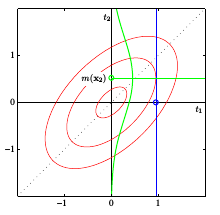

Fig.7 Illustration of the mechanism of Gaussian process regression for the case of one training point and one test point, in which the red el- lipses show contours of the joint dis- tribution p(t1 , t2 ). Here t1 is the training data point, and condition- ing on the value of t1 , correspond- ing to the vertical blue line, we ob- tain p(t2 |t1 ) shown as a function of t2 by the green curve.



## Gaussian Process Regression

### Definition of Gaussian Process for Regression

The observed target values $ t_n $ are modeled as:
$$
t_n = y_n + \epsilon_n
$$

where:

- $ y_n = y(x_n) $
- $ \epsilon_n \sim \mathcal{N}(0, \beta^{-1}) $

This implies the likelihood is:

$$
p(t_n | y_n) = \mathcal{N}(t_n | y_n, \beta^{-1})
$$

The joint distribution of the observed target values $ \mathbf{t} $ conditioned on $ \mathbf{y} $ is:

$$
p(\mathbf{t} | \mathbf{y}) = \mathcal{N}(\mathbf{t} | \mathbf{y}, \beta^{-1} \mathbf{I})
$$

From the definition of a Gaussian process, the marginal distribution \( p(\mathbf{y}) \) is:

$$
p(\mathbf{y}) = \mathcal{N}(\mathbf{y} | \mathbf{0}, \mathbf{K})
$$

where $ \mathbf{K} $ is the covariance matrix with elements $ K(x_n, x_m) = k(x_n, x_m) $.

### Kernel Function

The covariance function (kernel) is defined as:

$$
k(x_n, x_m) = \theta_0 \exp\left(-\frac{\|x_n - x_m\|^2}{2 \theta_1}\right) + \theta_2 + \theta_3 x_n^T x_m
$$

This kernel consists of:

1. A squared exponential term.
2. A constant term $( \theta_2 $).
3. A linear term $( \theta_3 x_n^T x_m $).

### Marginal Distribution of $ \mathbf{t} $

The marginal distribution $ p(\mathbf{t}) $ is:

$$
p(\mathbf{t}) = \int p(\mathbf{t} | \mathbf{y}) p(\mathbf{y}) d\mathbf{y} = \mathcal{N}(\mathbf{t} | \mathbf{0}, \mathbf{C})
$$

where:

$$
\mathbf{C} = \mathbf{K} + \beta^{-1} \mathbf{I}
$$

### Prediction for a New Test Point

For a new test input $ x_{N+1} $, the joint distribution of $ \mathbf{t} $ and $ t_{N+1} $ is:

$$
\begin{bmatrix}
\mathbf{t} \\
t_{N+1}
\end{bmatrix}
\sim \mathcal{N}\left(
\mathbf{0}, 
\begin{bmatrix}
\mathbf{C} & \mathbf{k} \\
\mathbf{k}^T & c
\end{bmatrix}
\right)
$$

where:

- $ \mathbf{k} = [k(x_1, x_{N+1}), \ldots, k(x_N, x_{N+1})]^T $
- $ c = k(x_{N+1}, x_{N+1}) + \beta^{-1} $

The predictive mean and variance are:

$$
m(x_{N+1}) = \mathbf{k}^T \mathbf{C}^{-1} \mathbf{t}
$$

$$
\sigma^2(x_{N+1}) = c - \mathbf{k}^T \mathbf{C}^{-1} \mathbf{k}
$$

These equations define the Gaussian process regression model.

---

## Computational Complexity

- Matrix inversion of $ \mathbf{C} $: $ \mathcal{O}(N^3) $
- For each test point:
  - Compute $ \mathbf{k}^T \mathbf{C}^{-1} $: $ \mathcal{O}(N^2) $

---

## Example Visualizations

### Figure 6.5: Gaussian Process Priors

For kernel parameters $ (\theta_0, \theta_1, \theta_2, \theta_3) $:

$$
(1.00, 4.00, 0.00, 0.00), \quad (9.00, 4.00, 0.00, 0.00), \quad (1.00, 64.00, 0.00, 0.00)
$$

Sample functions drawn from the GP prior:

$$
f(x) \sim \mathcal{GP}(0, k(x, x'))
$$

### Figure 6.8: Gaussian Process Regression

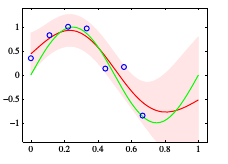

Fig.8 Illustration of Gaussian process regression applied to the sinusoidal data set in Figure A.6 in which the three right-most data points have been omitted. The green curve shows the sinusoidal function from which the data points, shown in blue, are obtained by sampling and addition of Gaussian noise. The red line shows the mean of the Gaussian process predictive distri- bution, and the shaded region corresponds to plus and minus two standard deviations. Notice how the uncertainty increases in the region to the right of the data points.
Training data points are shown with added Gaussian noise. The mean prediction is plotted along with the $ \pm 2 $-standard deviation confidence intervals.

$$
\text{Mean prediction: } m(x)
$$

$$
\text{Confidence interval: } [m(x) - 2\sigma(x), m(x) + 2\sigma(x)]
$$


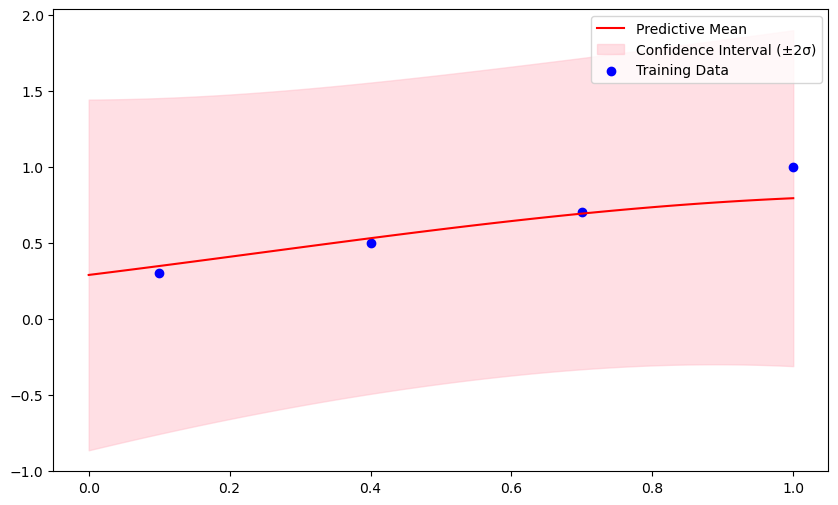

In [1]:
import math
import matplotlib.pyplot as plt

# Define the squared exponential kernel
def kernel(x1, x2, theta0=1.0, theta1=1.0, theta2=0.0, theta3=0.0):
    """Kernel function combining RBF, constant, and linear terms."""
    sqdist = sum((xi - yi) ** 2 for xi, yi in zip(x1, x2))
    rbf = theta0 * math.exp(-sqdist / (2 * theta1))
    constant = theta2
    linear = theta3 * sum(xi * yi for xi, yi in zip(x1, x2))
    return rbf + constant + linear

# Compute the covariance matrix
def covariance_matrix(X, kernel_func, theta_params, noise_variance=1e-6):
    """Computes the covariance matrix K(X, X) with added noise variance."""
    N = len(X)
    K = [[kernel_func(X[i], X[j], *theta_params) for j in range(N)] for i in range(N)]
    for i in range(N):
        K[i][i] += noise_variance
    return K

# Matrix inversion using Gaussian elimination
def invert_matrix(M):
    """Inverts a matrix M using Gaussian elimination."""
    n = len(M)
    identity = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
    for i in range(n):
        # Pivot
        pivot = M[i][i]
        for j in range(n):
            M[i][j] /= pivot
            identity[i][j] /= pivot
        for k in range(n):
            if k != i:
                factor = M[k][i]
                for j in range(n):
                    M[k][j] -= factor * M[i][j]
                    identity[k][j] -= factor * identity[i][j]
    return identity

# Matrix-vector multiplication
def mat_vec_mult(A, v):
    """Multiplies matrix A with vector v."""
    return [sum(A[i][j] * v[j] for j in range(len(v))) for i in range(len(A))]

# Gaussian Process Regression
def gaussian_process_regression(X_train, y_train, X_test, kernel_func, theta_params, beta=1.0):
    """Performs Gaussian Process Regression."""
    # Covariance matrix
    K = covariance_matrix(X_train, kernel_func, theta_params, noise_variance=1/beta)
    K_inv = invert_matrix([row[:] for row in K])  # Avoid modifying K
    
    # Compute mean and covariance for predictions
    means = []
    variances = []
    
    for x_test in X_test:
        k_star = [kernel_func(x_test, x_train, *theta_params) for x_train in X_train]
        k_star_T_K_inv = mat_vec_mult(K_inv, k_star)
        
        # Predictive mean
        mean = sum(k_star_T_K_inv[i] * y_train[i] for i in range(len(y_train)))
        means.append(mean)
        
        # Predictive variance
        k_star_star = kernel(x_test, x_test, *theta_params) + 1 / beta
        variance = k_star_star - sum(k_star_T_K_inv[i] * k_star[i] for i in range(len(k_star)))
        variances.append(variance)
    
    return means, variances

# Plotting function
def plot_gp(X_train, y_train, X_test, means, variances):
    """Plots the GP prediction along with training data."""
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, means, 'r', label='Predictive Mean')
    plt.fill_between(
        [x[0] for x in X_test],
        [m - 2 * math.sqrt(v) for m, v in zip(means, variances)],
        [m + 2 * math.sqrt(v) for m, v in zip(means, variances)],
        color='pink', alpha=0.5, label='Confidence Interval (±2σ)'
    )
    plt.scatter([x[0] for x in X_train], y_train, c='blue', label='Training Data')
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Training data
    X_train = [[0.1], [0.4], [0.7], [1.0]]
    y_train = [0.3, 0.5, 0.7, 1.0]
    
    # Test data
    X_test = [[i / 100] for i in range(101)]
    
    # Kernel parameters
    theta_params = (1.0, 1.0, 0.0, 0.0)
    
    # Perform Gaussian Process Regression
    means, variances = gaussian_process_regression(
        X_train, y_train, X_test, kernel, theta_params, beta=5.0
    )
    
    # Plot the results
    plot_gp(X_train, y_train, X_test, means, variances)


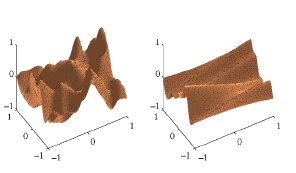

Fig.9 Samples from the ARD prior for Gaussian processes, in which the kernel function is given by (6.71). The left plot corresponds to η1 = η2 = 1, and the right plot corresponds to η1 = 1, η2 = 0.01.

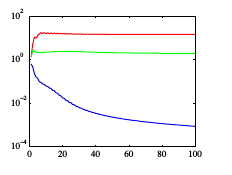

Fig.10 Illustration of automatic rele- vance determination in a Gaus- sian process for a synthetic prob- lem having three inputs x1 , x2 , and x3 , for which the curves show the corresponding values of the hyperparameters η1 (red), η2 (green), and η3 (blue) as a func- tion of the number of iterations when optimizing the marginal likelihood. Details are given in the text. Note the logarithmic scale on the vertical axis.

## Learning the Hyperparameters in Gaussian Process Regression

## Covariance Function and Hyperparameters
The predictions of a Gaussian process (GP) model depend on the choice of the covariance function. Instead of fixing this function, we may prefer to use a parametric family of functions and infer the parameter values (hyperparameters) from data. These parameters, denoted as $\theta$, govern properties like the correlation length scale and noise precision. 

### Log-Likelihood Function
The hyperparameters can be optimized by maximizing the log likelihood function:
$$
\ln p(t|\theta) = -\frac{1}{2} \ln |C_N| - \frac{1}{2} \mathbf{t}^\top C_N^{-1} \mathbf{t} - \frac{N}{2} \ln (2\pi),
$$
where:
- $C_N$ is the covariance matrix with elements $[C_N]_{ij} = k(x_i, x_j) + \beta^{-1} \delta_{ij}$,
- $\mathbf{t}$ is the target vector,
- $N$ is the number of training points,
- $\beta$ is the noise precision.

### Gradient of the Log-Likelihood
The gradient of $\ln p(t|\theta)$ with respect to a hyperparameter $\theta_i$ is:
$$
\frac{\partial \ln p(t|\theta)}{\partial \theta_i} = -\frac{1}{2} \text{Tr} \left( C_N^{-1} \frac{\partial C_N}{\partial \theta_i} \right) + \frac{1}{2} \mathbf{t}^\top C_N^{-1} \frac{\partial C_N}{\partial \theta_i} C_N^{-1} \mathbf{t}.
$$

### Optimization
Since $\ln p(t|\theta)$ is generally nonconvex, it may have multiple maxima. Gradient-based methods like **conjugate gradients** or **scaled conjugate gradients** are commonly used for optimization.

---

## Automatic Relevance Determination (ARD)
In ARD, separate parameters $\eta_i$ are introduced for each input variable, allowing the GP model to infer the relative importance of inputs.

### ARD Kernel Function
The kernel function for ARD in a two-dimensional input space $x = (x_1, x_2)$ is given by:
$$
k(x, x') = \theta_0 \exp\left(-\frac{1}{2} \sum_{i=1}^2 \eta_i (x_i - x_i')^2 \right).
$$

When extended to $D$ dimensions, the ARD kernel becomes:
$$
k(x_n, x_m) = \theta_0 \exp\left(-\frac{1}{2} \sum_{i=1}^D \eta_i (x_{ni} - x_{mi})^2\right) + \theta_2 + \theta_3 \sum_{i=1}^D x_{ni} x_{mi}.
$$

### Illustration of ARD
- As $\eta_i$ becomes small, the kernel function becomes less sensitive to the corresponding input $x_i$.
- By optimizing $\eta_i$ values using the marginal likelihood, irrelevant inputs can be detected (low $\eta_i$ values).

---

## Key Insights
1. **Hyperparameter Learning**: The parameters $\theta$ (e.g., $\theta_0$, $\eta_i$) control GP behavior and can be learned using maximum likelihood or Bayesian inference.
2. **Gradient-Based Optimization**: Log-likelihood gradients enable efficient optimization for large-scale problems.
3. **ARD for Feature Selection**: ARD helps identify irrelevant inputs by analyzing the sensitivity of the kernel function to each input variable.

---



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21584D+02    |proj g|=  2.90537D+01


 This problem is unconstrained.
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



At iterate    1    f=  1.21584D+02    |proj g|=  2.90537D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1      3      1     0     0   2.905D+01   1.216D+02
  F =   121.58377931982785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


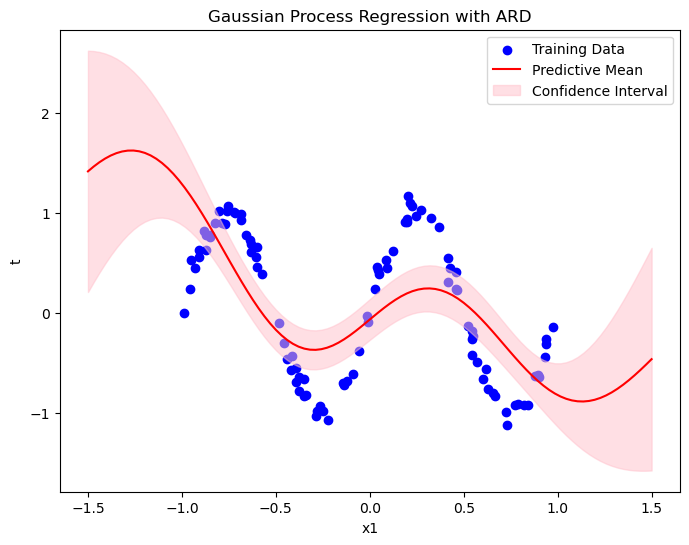

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the ARD kernel
def ard_kernel(x1, x2, params):
    theta0, eta, theta2, theta3 = params['theta0'], params['eta'], params['theta2'], params['theta3']
    dist = np.sum([eta[i] * (x1[:, i:i+1] - x2[:, i])**2 for i in range(x1.shape[1])], axis=0)
    kernel = theta0 * np.exp(-0.5 * dist) + theta2 + theta3 * np.dot(x1, x2.T)
    return kernel

# Gaussian Process log-likelihood
def gp_log_likelihood(params_vector, X, y, params_template):
    params = params_template.copy()
    params['theta0'], params['theta2'], params['theta3'] = params_vector[0], params_vector[-2], params_vector[-1]
    params['eta'] = np.exp(params_vector[1:-2])  # Positive constraints on eta using exp()
    
    K = ard_kernel(X, X, params) + np.eye(X.shape[0]) * params['noise']
    try:
        L = np.linalg.cholesky(K)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        log_likelihood = -0.5 * np.dot(y.T, alpha) - np.sum(np.log(np.diagonal(L))) - 0.5 * X.shape[0] * np.log(2 * np.pi)
        return -log_likelihood  # Negative because we minimize
    except np.linalg.LinAlgError:
        return np.inf

# Fit the Gaussian Process
def optimize_hyperparameters(X, y, initial_params):
    params_vector = np.hstack([initial_params['theta0'], np.log(initial_params['eta']), initial_params['theta2'], initial_params['theta3']])
    result = minimize(
        gp_log_likelihood,
        params_vector,
        args=(X, y, initial_params),
        method='L-BFGS-B',
        options={'disp': True}
    )
    return result

# Prediction with Gaussian Process
def gp_predict(X_train, y_train, X_test, params):
    K = ard_kernel(X_train, X_train, params) + np.eye(X_train.shape[0]) * params['noise']
    K_s = ard_kernel(X_train, X_test, params)
    K_ss = ard_kernel(X_test, X_test, params) + 1e-8 * np.eye(X_test.shape[0])  # Small noise for numerical stability
    
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    # Predict mean and variance
    mean = np.dot(K_s.T, alpha)
    v = np.linalg.solve(L, K_s)
    variance = K_ss - np.dot(v.T, v)
    return mean, np.diagonal(variance)

# Synthetic Dataset for Testing ARD
np.random.seed(42)
N = 100
X1 = np.random.uniform(-1, 1, N)[:, None]
X2 = X1 + 0.1 * np.random.normal(size=(N, 1))
X3 = np.random.normal(size=(N, 1))
X = np.hstack([X1, X2, X3])
y = np.sin(2 * np.pi * X1).ravel() + 0.1 * np.random.normal(size=N)

# Initial Hyperparameters
initial_params = {
    'theta0': 1.0,
    'eta': [1.0, 1.0, 1.0],
    'theta2': 1e-5,
    'theta3': 1e-5,
    'noise': 0.1
}

# Optimize hyperparameters
result = optimize_hyperparameters(X, y, initial_params)

# Extract optimized parameters
opt_params = initial_params.copy()
opt_params['theta0'], opt_params['theta2'], opt_params['theta3'] = result.x[0], result.x[-2], result.x[-1]
opt_params['eta'] = np.exp(result.x[1:-2])

# Predictions
X_test = np.linspace(-1.5, 1.5, 100)[:, None]
X_test_full = np.hstack([X_test, X_test, np.zeros_like(X_test)])
mean, variance = gp_predict(X, y, X_test_full, opt_params)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], y, color='blue', label='Training Data')
plt.plot(X_test, mean, color='red', label='Predictive Mean')
plt.fill_between(
    X_test.ravel(),
    mean - 2 * np.sqrt(variance),
    mean + 2 * np.sqrt(variance),
    color='pink',
    alpha=0.5,
    label='Confidence Interval'
)
plt.xlabel('x1')
plt.ylabel('t')
plt.legend()
plt.title('Gaussian Process Regression with ARD')
plt.show()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13502D+01    |proj g|=  2.51656D+01


 This problem is unconstrained.



At iterate    1    f=  5.57130D+01    |proj g|=  1.44860D+01

At iterate    2    f=  3.59337D+01    |proj g|=  6.94732D+00

At iterate    3    f=  3.59337D+01    |proj g|=  6.94732D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3      5      1     0     0   6.947D+00   3.593D+01
  F =   35.933669051143184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


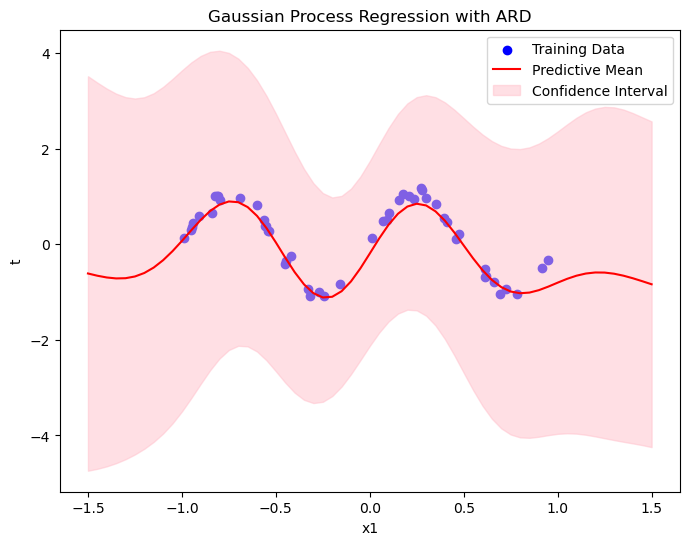

In [3]:
import math
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt

# Define basic matrix operations for Python lists
def transpose(matrix):
    return list(map(list, zip(*matrix)))

def dot(A, B):
    return [[sum(a * b for a, b in zip(row, col)) for col in transpose(B)] for row in A]

def matrix_add(A, B):
    return [[a + b for a, b in zip(row_a, row_b)] for row_a, row_b in zip(A, B)]

def matrix_sub(A, B):
    return [[a - b for a, b in zip(row_a, row_b)] for row_a, row_b in zip(A, B)]

def identity_matrix(size):
    return [[1 if i == j else 0 for j in range(size)] for i in range(size)]

def cholesky_decomposition(A):
    n = len(A)
    L = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(i + 1):
            s = sum(L[i][k] * L[j][k] for k in range(j))
            L[i][j] = math.sqrt(A[i][i] - s) if i == j else (A[i][j] - s) / L[j][j]
    return L

def inverse(L):
    n = len(L)
    L_inv = [[0.0] * n for _ in range(n)]
    for i in range(n):
        L_inv[i][i] = 1.0 / L[i][i]
        for j in range(i + 1, n):
            L_inv[j][i] = -sum(L[j][k] * L_inv[k][i] for k in range(i, j + 1)) / L[j][j]
    return dot(transpose(L_inv), L_inv)

# Define ARD kernel
def ard_kernel(x1, x2, params):
    theta0, eta, theta2, theta3 = params['theta0'], params['eta'], params['theta2'], params['theta3']
    kernel = []
    for i in range(len(x1)):
        row = []
        for j in range(len(x2)):
            dist = sum(eta[k] * (x1[i][k] - x2[j][k]) ** 2 for k in range(len(eta)))
            value = theta0 * math.exp(-0.5 * dist) + theta2 + theta3 * sum(x1[i][k] * x2[j][k] for k in range(len(x1[0])))
            row.append(value)
        kernel.append(row)
    return kernel

# Log-likelihood for Gaussian Process
def gp_log_likelihood(params_vector, X, y, params_template):
    params = params_template.copy()
    params['theta0'], params['theta2'], params['theta3'] = params_vector[0], params_vector[-2], params_vector[-1]
    params['eta'] = [math.exp(v) for v in params_vector[1:-2]]

    K = matrix_add(ard_kernel(X, X, params), [[params['noise'] if i == j else 0 for j in range(len(X))] for i in range(len(X))])
    try:
        L = cholesky_decomposition(K)
        K_inv = inverse(L)
        alpha = dot(K_inv, [[y[i]] for i in range(len(y))])
        log_likelihood = -0.5 * sum(y[i] * alpha[i][0] for i in range(len(y))) - sum(math.log(L[i][i]) for i in range(len(L))) - 0.5 * len(X) * math.log(2 * math.pi)
        return -log_likelihood  # Negative because we minimize
    except Exception:
        return float('inf')

# Fit Gaussian Process
def optimize_hyperparameters(X, y, initial_params):
    params_vector = [initial_params['theta0']] + [math.log(v) for v in initial_params['eta']] + [initial_params['theta2'], initial_params['theta3']]
    result = minimize(
        gp_log_likelihood,
        params_vector,
        args=(X, y, initial_params),
        method='L-BFGS-B',
        options={'disp': True}
    )
    return result

# Predictions
def gp_predict(X_train, y_train, X_test, params):
    K = matrix_add(ard_kernel(X_train, X_train, params), [[params['noise'] if i == j else 0 for j in range(len(X_train))] for i in range(len(X_train))])
    K_s = ard_kernel(X_train, X_test, params)
    K_ss = ard_kernel(X_test, X_test, params)
    
    L = cholesky_decomposition(K)
    K_inv = inverse(L)
    alpha = dot(K_inv, [[y_train[i]] for i in range(len(y_train))])
    
    # Predictive mean and variance
    mean = dot(transpose(K_s), alpha)
    v = dot(K_inv, K_s)
    variance = matrix_sub(K_ss, dot(transpose(v), v))
    return [mean[i][0] for i in range(len(mean))], [variance[i][i] for i in range(len(variance))]

# Synthetic Dataset
random.seed(42)
N = 50
X1 = [[random.uniform(-1, 1)] for _ in range(N)]
X2 = [[x[0] + 0.1 * random.gauss(0, 1)] for x in X1]
X3 = [[random.gauss(0, 1)] for _ in range(N)]
X = [x1 + x2 + x3 for x1, x2, x3 in zip(X1, X2, X3)]
y = [math.sin(2 * math.pi * x[0]) + 0.1 * random.gauss(0, 1) for x in X]

# Initial Hyperparameters
initial_params = {
    'theta0': 1.0,
    'eta': [1.0, 1.0, 1.0],
    'theta2': 1e-5,
    'theta3': 1e-5,
    'noise': 0.1
}

# Optimize hyperparameters
result = optimize_hyperparameters(X, y, initial_params)

# Extract optimized parameters
opt_params = initial_params.copy()
opt_params['theta0'], opt_params['theta2'], opt_params['theta3'] = result.x[0], result.x[-2], result.x[-1]
opt_params['eta'] = [math.exp(v) for v in result.x[1:-2]]

# Predictions
X_test = [[x, x, 0.0] for x in [i * 0.05 for i in range(-30, 31)]]
mean, variance = gp_predict(X, y, X_test, opt_params)

# Plot Results
plt.figure(figsize=(8, 6))
plt.scatter([x[0] for x in X], y, color='blue', label='Training Data')
plt.plot([x[0] for x in X_test], mean, color='red', label='Predictive Mean')
plt.fill_between(
    [x[0] for x in X_test],
    [m - 2 * math.sqrt(v) for m, v in zip(mean, variance)],
    [m + 2 * math.sqrt(v) for m, v in zip(mean, variance)],
    color='pink',
    alpha=0.5,
    label='Confidence Interval'
)
plt.xlabel('x1')
plt.ylabel('t')
plt.legend()
plt.title('Gaussian Process Regression with ARD')
plt.show()
